# Initialization

In [1]:
# code developed in Python 3.12
!python --version

Python 3.12.4


In [2]:
# install modules
!pip install -r requirements.txt --disable-pip-version-check | tail -n 5

In [3]:
import re,sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import humanize as hm
from tqdm import tqdm
tqdm.pandas(file=sys.stdout,ncols=100)

## Setup

In [4]:
# size of train and test datasets
SET_SIZE = 100000

# minor language speaking countries in EU
COUNTRY_MI = ['CZ', 'DK', 'EE', 'HR', 'HU', 'LT', 'LV', 'PL', 'RO', 'RS', 'SI', 'SK']

# English and major language speaking countries
COUNTRY_MJ = ['UK','DE','FR','ES']

# for word clouds
STOPWORDS = ('http','www','https','php','html','htm','index','tag') 

## Functions

In [5]:
def frame_info(frame,samples=5):

    size = len(frame)  
    
    frame_sample = frame.sample(min(samples,size))
    display(frame_sample)

    mem = frame.memory_usage(deep=True).sum()
    
    print(f'Size {size}, Memory {hm.naturalsize(mem)}')
    print(frame.dtypes)

    return

In [6]:
def word_cloud(url):

    # remove terms with numbers
    url = [item for item in url if not re.search(r'\d', item)]
    
    text = ' '.join(url)
    
    wordcloud = WordCloud(collocations = False, normalize_plurals = False, 
                          max_words = 200, stopwords = STOPWORDS, 
                          background_color = 'white').generate(text)
    
    plt.imshow(wordcloud, interpolation = "bilinear" )
    plt.axis('off')

    return plt

# Load and process data

## Phishing data

In [7]:
# https://github.com/mitchellkrogza/Phishing.Database
phishing_data = pd.read_csv('phishing-urls/phishing-urls.txt',on_bad_lines='skip',names=['url'])
phishing_data['phishing'] = True

phishing_data.url = phishing_data.url.apply(
    lambda x: x.replace('http://', '').replace('https://', ''))

phishing_data.url = phishing_data.url.astype(pd.StringDtype('pyarrow'))
frame_info(phishing_data)

,url,phishing
1067215,www.david-lane.net,True
381217,organisasi.bulungan.go.id/public/JtXN83UVh8ufd...,True
1077623,www.hasweas.com/acc.updat.shaw,True
753418,mass7389-jupi3894-3wzx34.wl.r.appspot.com,True
232778,gphzpjpdzjlmsvkc-dot-millinium.ey.r.appspot.com,True


Size 1110651, Memory 83.1 MB
url         string[pyarrow]
phishing               bool
dtype: object


In [8]:
# split train test
phishing_data = phishing_data.sample(frac=1,random_state=0)
phishing_train = phishing_data.iloc[0:SET_SIZE]
phishing_test = phishing_data.iloc[SET_SIZE:SET_SIZE+1000000]
del phishing_data

In [9]:
frame_info(phishing_train)

,url,phishing
246493,hatac.net/28abda07429259b6d2c90894cabd5dbd/c79...,True
1058378,www.amazcecm-co-jp.amazaeon.chalvshe.top,True
551685,bofamwc.com/QKKVjSVEUsUQKokHY/index.html,True
317551,m3dfrance.com/fr/wp-includes/Text/Diff/Rendere...,True
352032,mtbconnect.selfip.com/6df29ab6894eacc985020d19...,True


Size 100000, Memory 8.3 MB
url         string[pyarrow]
phishing               bool
dtype: object


In [10]:
frame_info(phishing_test)

,url,phishing
849787,saharaindiapackers.com/consumms/Odrivex,True
547152,bit.ly/3zc21yF,True
889910,supervisionthestudio.com/Pcccccooo/Odrivex/ind...,True
350465,mouhinjoma.blogspot.com,True
957265,www.antlergroup.com/wp-content/themes/antler/f...,True


Size 1000000, Memory 82.9 MB
url         string[pyarrow]
phishing               bool
dtype: object


## Generic data

In [11]:
# https://commoncrawl.github.io/cc-crawl-statistics/
generic_data = pd.read_csv(f'benign-urls/urls-GENERIC.csv',engine='pyarrow')
generic_data['phishing'] = False
generic_data.url = generic_data.url.astype(pd.StringDtype('pyarrow'))
generic_data.tld = generic_data.tld.astype('category')
frame_info(generic_data)

,url,tld,phishing
700649,krgdb4.ucoz.ru/index/vyshestojashhie_kontrolir...,ru,False
313247,www.eurailpress.de/nachrichten/unternehmen-mae...,de,False
897663,www.mm-intercom.si/izdelki/transportna-tehnika...,si,False
45968,www.ginetteetjosiane.com/alimentations-vegetar...,com,False
187525,freerentcontest.com/images/review.html,com,False


Size 1000000, Memory 82.2 MB
url         string[pyarrow]
tld                category
phishing               bool
dtype: object


In [12]:
# split train test
generic_data = generic_data.sample(frac=1,random_state=0)
generic_train = generic_data.iloc[0:SET_SIZE]
generic_test = generic_data.iloc[SET_SIZE:SET_SIZE*2]

In [13]:
frame_info(generic_train)

,url,tld,phishing
631628,home.mengelke.de/linux/ubuntu_anwenderhandbuch...,de,False
43015,datenrettung.net/datenrettung-garching/,net,False
991621,index.library.tu.ac.th/cgi-bin/koha/opac-searc...,th,False
548523,santanrfs.com/product/iver-johnson-magazine-1911/,com,False
364763,enciwinner2017.it/location-de-villa-de-luxe-vi...,it,False


Size 100000, Memory 9.1 MB
url         string[pyarrow]
tld                category
phishing               bool
dtype: object


In [14]:
frame_info(generic_test)

,url,tld,phishing
643815,odigos.eviaportal.gr/dir/chalkidas-24o-nipiago...,gr,False
924528,www.ayelet.org.il/cgi-webaxy/sal/sal.pl?lang=h...,il,False
338496,sahiry.com/buyers/,com,False
690143,ainsi-va-le-monde.blogspot.com/2017/04/vingt-h...,com,False
75805,partyfurniturehire.co.uk/portfolio-item/table-...,uk,False


Size 100000, Memory 9.1 MB
url         string[pyarrow]
tld                category
phishing               bool
dtype: object


## Country data

In [15]:
country_data = pd.DataFrame()

for item in COUNTRY_MI+COUNTRY_MJ:
    item_data = pd.read_csv(f'benign-urls/urls-{item}.csv',engine='pyarrow')
    country_data = pd.concat([country_data,item_data],ignore_index=True)

country_data.url = country_data.url.astype(pd.StringDtype('pyarrow'))
country_data.country = country_data.country.astype('category')
country_data['phishing'] = False
frame_info(country_data)

,url,country,phishing
112973,www.leonara.cz/cerne-paskove-sandaly-endless/,CZ,False
1298121,www.notino.si/clean-clear/,SI,False
284404,draama2010.festival.ee/?id=217,EE,False
1324472,plemljevavila.dmfa.si/Tekmovanja/MaOS/ArhivNov...,SI,False
1482055,www.pohodadomova.sk/gulovy-ventil/Herz-vypusta...,SK,False


Size 2000000, Memory 159.8 MB
url         string[pyarrow]
country            category
phishing               bool
dtype: object


In [16]:
# no of web urls per country
print(dict(country_data.country.value_counts()))

{'CZ': 125000, 'DE': 125000, 'DK': 125000, 'EE': 125000, 'ES': 125000, 'FR': 125000, 'HR': 125000, 'HU': 125000, 'LT': 125000, 'LV': 125000, 'PL': 125000, 'RO': 125000, 'RS': 125000, 'SI': 125000, 'SK': 125000, 'UK': 125000}


In [17]:
# split train test
country_train = pd.DataFrame()
country_test = pd.DataFrame()

for item in COUNTRY_MI+COUNTRY_MJ:
    data = country_data.loc[country_data.country == item]
    data = data.sample(frac=1,random_state=0)
    data_train = data.iloc[0:25000]
    data_test = data.iloc[25000:125000]

    country_train = pd.concat([data_train,country_train],ignore_index=True)
    country_test = pd.concat([data_test,country_test],ignore_index=True)

In [18]:
# no of train web urls per country
print(dict(country_train.country.value_counts()))

{'CZ': 25000, 'DE': 25000, 'DK': 25000, 'EE': 25000, 'ES': 25000, 'FR': 25000, 'HR': 25000, 'HU': 25000, 'LT': 25000, 'LV': 25000, 'PL': 25000, 'RO': 25000, 'RS': 25000, 'SI': 25000, 'SK': 25000, 'UK': 25000}


In [19]:
# no of test web urls per country
print(dict(country_test.country.value_counts()))

{'CZ': 100000, 'DE': 100000, 'DK': 100000, 'EE': 100000, 'ES': 100000, 'FR': 100000, 'HR': 100000, 'HU': 100000, 'LT': 100000, 'LV': 100000, 'PL': 100000, 'RO': 100000, 'RS': 100000, 'SI': 100000, 'SK': 100000, 'UK': 100000}


# Create models

In [20]:
# vectorize by tf-idf
vectorizer = TfidfVectorizer()
vectorizer.fit(pd.concat([country_train,generic_train,phishing_train],ignore_index=True).url);

## Common detection

In [21]:
data = pd.concat([generic_train,phishing_train],ignore_index=True)
print(data.phishing.value_counts())

model = MultinomialNB()
feature = vectorizer.transform(data.url)
model_common = model.fit(feature,data.phishing)

phishing
False    100000
True     100000
Name: count, dtype: int64


## Language-based detection

In [22]:
country_language = country_train.loc[country_train.country.isin(COUNTRY_MI)]
data = pd.concat([country_language.sample(len(phishing_train),random_state=0),
                  phishing_train],ignore_index=True)
print(data.phishing.value_counts())

model = MultinomialNB()
feature = vectorizer.transform(data.url)
model_language = model.fit(feature,data.phishing)

phishing
False    100000
True     100000
Name: count, dtype: int64


# Phishing detection

In [23]:
country_results = pd.DataFrame()

for item in COUNTRY_MI+COUNTRY_MJ:
    
    print(f'### {item} ',end='')
    single_country_test = country_test.loc[country_test.country == item]
    data = pd.concat([single_country_test,phishing_test.sample(
        len(single_country_test),random_state=(COUNTRY_MI+COUNTRY_MJ).index(item))],ignore_index=True)
    print(f'phishing {data.phishing.value_counts().to_dict()}')
    
    feature = vectorizer.transform(data.url)
    
    ## common ##
    data['common'] = model_common.predict(feature)
    report = classification_report(data.phishing,data.common)

    print()
    print('Common detection')
    print(report)
    
    with open(f'result-reports/report-common-{item}.txt', 'w') as report_file:
        report_file.write(report)

    cm_raw = confusion_matrix(data.phishing,data.common).round(3)
    cm_norm = confusion_matrix(data.phishing,data.common,normalize="true").round(3)
    country_common_raw = cm_raw.ravel()
    country_common_norm = cm_norm.ravel()
    print(f'tn,fp,fn,tp raw {country_common_raw}')
    print(f'tn,fp,fn,tp normed {country_common_norm}')

    fig, ax = plt.subplots(figsize=(3, 3))
    ConfusionMatrixDisplay(cm_norm).plot(ax=ax,colorbar=False)
    plt.savefig(f'result-figures/fig-matrix-common-{item}.pdf',bbox_inches='tight',pad_inches=0)
    plt.close(fig)
    print()

    ## language-based ##

    if item in COUNTRY_MI:    
        data['language'] = model_language.predict(feature)
        report = classification_report(data.phishing,data.language)
    
        print('Geospatial detection')
        print(report)
        
        with open(f'result-reports/report-language-{item}.txt', 'w') as report_file:
            report_file.write(report)
        
        cm_raw = confusion_matrix(data.phishing,data.language).round(3)
        cm_norm = confusion_matrix(data.phishing,data.language,normalize="true").round(3)
        country_language_raw = cm_raw.ravel()
        country_language_norm = cm_norm.ravel()
        print(f'tn,fp,fn,tp raw {country_language_raw}')
        print(f'tn,fp,fn,tp normed {country_language_norm}')
    
        fig, ax = plt.subplots(figsize=(3, 3))
        ConfusionMatrixDisplay(cm_norm).plot(ax=ax,colorbar=False)
        plt.savefig(f'result-figures/fig-matrix-language-{item}.pdf',bbox_inches='tight',pad_inches=0)
        plt.close(fig)
        
        data.to_csv(f'result-raw/raw-common-language-{item}.csv', index=False)
        improvement =  data.loc[(data.phishing == False) & (data.common == True) & (data.language == False)]
        improvement.to_csv(f'result-improved/improved-common-language-{item}.csv', index=False)
        print('\nSample improved detections')
        display(improvement.sample(5))
    
        result = {'country':item,
                  'fp_common':country_common_norm[1],'fn_common':country_common_norm[2],
                  'fp_language':country_language_norm[1],'fn_language':country_language_norm[2]
                 }
    
        country_results = pd.concat([pd.DataFrame([result]),country_results],ignore_index=True)

### CZ phishing {False: 100000, True: 100000}

Common detection
              precision    recall  f1-score   support

       False       0.95      0.99      0.97    100000
        True       0.99      0.95      0.97    100000

    accuracy                           0.97    200000
   macro avg       0.97      0.97      0.97    200000
weighted avg       0.97      0.97      0.97    200000

tn,fp,fn,tp raw [99149   851  5223 94777]
tn,fp,fn,tp normed [0.991 0.009 0.052 0.948]

Geospatial detection
              precision    recall  f1-score   support

       False       0.99      1.00      0.99    100000
        True       1.00      0.99      0.99    100000

    accuracy                           0.99    200000
   macro avg       0.99      0.99      0.99    200000
weighted avg       0.99      0.99      0.99    200000

tn,fp,fn,tp raw [99600   400  1444 98556]
tn,fp,fn,tp normed [0.996 0.004 0.014 0.986]

Sample improved detections


,url,country,phishing,common,language
24058,vidce.cz/wp-content/files/oldud/1856.pdf,CZ,False,True,False
14049,www.schmiedmann.cz/cs/tahla-pg171-catn-oa,CZ,False,True,False
15485,podpora.endora.cz/profile.php?id=112459,CZ,False,True,False
51770,www.moolbike.cz/stredove-osy/osa-zap--ch--127m...,CZ,False,True,False
6795,mazivaonline.cz/plasticka-maziva/205-shell-gad...,CZ,False,True,False


### DK phishing {False: 100000, True: 100000}

Common detection
              precision    recall  f1-score   support

       False       0.95      0.98      0.97    100000
        True       0.98      0.95      0.97    100000

    accuracy                           0.97    200000
   macro avg       0.97      0.97      0.97    200000
weighted avg       0.97      0.97      0.97    200000

tn,fp,fn,tp raw [98392  1608  5260 94740]
tn,fp,fn,tp normed [0.984 0.016 0.053 0.947]

Geospatial detection
              precision    recall  f1-score   support

       False       0.99      0.99      0.99    100000
        True       0.99      0.99      0.99    100000

    accuracy                           0.99    200000
   macro avg       0.99      0.99      0.99    200000
weighted avg       0.99      0.99      0.99    200000

tn,fp,fn,tp raw [99196   804  1488 98512]
tn,fp,fn,tp normed [0.992 0.008 0.015 0.985]

Sample improved detections


,url,country,phishing,common,language
35832,rabo.dk/brand/aerotec/,DK,False,True,False
57014,livejasmin.dk/chat/yivercamarillo,DK,False,True,False
32755,www.feldbergstrandcamping.dk/gammel_fotos/page...,DK,False,True,False
37123,bisgaard-clausen.dk/Tovefam.web/per00318.htm,DK,False,True,False
5693,www.langelandkommune.dk/Files/Files/Borger/Bol...,DK,False,True,False


### EE phishing {False: 100000, True: 100000}

Common detection
              precision    recall  f1-score   support

       False       0.95      0.94      0.94    100000
        True       0.94      0.95      0.94    100000

    accuracy                           0.94    200000
   macro avg       0.94      0.94      0.94    200000
weighted avg       0.94      0.94      0.94    200000

tn,fp,fn,tp raw [93705  6295  5100 94900]
tn,fp,fn,tp normed [0.937 0.063 0.051 0.949]

Geospatial detection
              precision    recall  f1-score   support

       False       0.99      0.99      0.99    100000
        True       0.99      0.99      0.99    100000

    accuracy                           0.99    200000
   macro avg       0.99      0.99      0.99    200000
weighted avg       0.99      0.99      0.99    200000

tn,fp,fn,tp raw [99373   627  1403 98597]
tn,fp,fn,tp normed [0.994 0.006 0.014 0.986]

Sample improved detections


,url,country,phishing,common,language
97768,www.saalihoki.ee/Protokoll.aspx?id=J7Z7WDTDYDs...,EE,False,True,False
61230,laansoo.ee/4estd1989_zievert-shampinjon-arihoone/,EE,False,True,False
17653,nullkulu.ee/milline-piimasegu-parim/,EE,False,True,False
57903,www.iha.ee/users/Justin2,EE,False,True,False
89060,www.maainfo.ee/index.php?id=7954&page=3394&,EE,False,True,False


### HR phishing {False: 100000, True: 100000}

Common detection
              precision    recall  f1-score   support

       False       0.95      0.98      0.96    100000
        True       0.98      0.95      0.96    100000

    accuracy                           0.96    200000
   macro avg       0.96      0.96      0.96    200000
weighted avg       0.96      0.96      0.96    200000

tn,fp,fn,tp raw [97863  2137  5129 94871]
tn,fp,fn,tp normed [0.979 0.021 0.051 0.949]

Geospatial detection
              precision    recall  f1-score   support

       False       0.99      1.00      0.99    100000
        True       1.00      0.99      0.99    100000

    accuracy                           0.99    200000
   macro avg       0.99      0.99      0.99    200000
weighted avg       0.99      0.99      0.99    200000

tn,fp,fn,tp raw [99742   258  1417 98583]
tn,fp,fn,tp normed [0.997 0.003 0.014 0.986]

Sample improved detections


,url,country,phishing,common,language
7207,puce.hr/lezaj-nomaroper,HR,False,True,False
20691,lokalnahrvatska.hr/vijest.php?nw=1482_1535362991,HR,False,True,False
12791,avantgarde.ns1.efortis.hr/vrsta/recenzija/,HR,False,True,False
85144,interalfa.hr/index.php/checkout/,HR,False,True,False
44815,artliving-realestate.hr/apartmaj/istra-porec-o...,HR,False,True,False


### HU phishing {False: 100000, True: 100000}

Common detection
              precision    recall  f1-score   support

       False       0.95      0.98      0.96    100000
        True       0.98      0.95      0.96    100000

    accuracy                           0.96    200000
   macro avg       0.96      0.96      0.96    200000
weighted avg       0.96      0.96      0.96    200000

tn,fp,fn,tp raw [97774  2226  5107 94893]
tn,fp,fn,tp normed [0.978 0.022 0.051 0.949]

Geospatial detection
              precision    recall  f1-score   support

       False       0.99      0.99      0.99    100000
        True       0.99      0.99      0.99    100000

    accuracy                           0.99    200000
   macro avg       0.99      0.99      0.99    200000
weighted avg       0.99      0.99      0.99    200000

tn,fp,fn,tp raw [99353   647  1432 98568]
tn,fp,fn,tp normed [0.994 0.006 0.014 0.986]

Sample improved detections


,url,country,phishing,common,language
36322,www.efitnesszuglo.hu/otp-ingyenes-szamlacsomag...,HU,False,True,False
50699,ado.hu/ado/megjelent-a-negygyerekes-nok-szja-m...,HU,False,True,False
45393,www.derimuzeum.hu/kiallitasok.php?id=40&amp;ak...,HU,False,True,False
88691,banyasz.hu/index.php/home/nemzetkozi,HU,False,True,False
71607,webuni.hu/kepzes/micro-bit-alapok,HU,False,True,False


### LT phishing {False: 100000, True: 100000}

Common detection
              precision    recall  f1-score   support

       False       0.95      0.96      0.96    100000
        True       0.96      0.95      0.95    100000

    accuracy                           0.95    200000
   macro avg       0.95      0.95      0.95    200000
weighted avg       0.95      0.95      0.95    200000

tn,fp,fn,tp raw [96092  3908  5114 94886]
tn,fp,fn,tp normed [0.961 0.039 0.051 0.949]

Geospatial detection
              precision    recall  f1-score   support

       False       0.99      1.00      0.99    100000
        True       1.00      0.99      0.99    100000

    accuracy                           0.99    200000
   macro avg       0.99      0.99      0.99    200000
weighted avg       0.99      0.99      0.99    200000

tn,fp,fn,tp raw [99615   385  1412 98588]
tn,fp,fn,tp normed [0.996 0.004 0.014 0.986]

Sample improved detections


,url,country,phishing,common,language
34736,sauliusspurga.lt/a-valinskas-uz-politinio-popu...,LT,False,True,False
6767,zenklas.lt/index.php?route=common/home,LT,False,True,False
54465,mamosdienorastis.lt/index.php?p=6&sub=6534,LT,False,True,False
94404,infveikla.puslapiai.lt/darbai/testai/testas_k.htm,LT,False,True,False
72300,etikostarnyba.lt/skelbiamas-konkursas-i-akadem...,LT,False,True,False


### LV phishing {False: 100000, True: 100000}

Common detection
              precision    recall  f1-score   support

       False       0.95      0.98      0.97    100000
        True       0.98      0.95      0.97    100000

    accuracy                           0.97    200000
   macro avg       0.97      0.97      0.97    200000
weighted avg       0.97      0.97      0.97    200000

tn,fp,fn,tp raw [98186  1814  5068 94932]
tn,fp,fn,tp normed [0.982 0.018 0.051 0.949]

Geospatial detection
              precision    recall  f1-score   support

       False       0.99      1.00      0.99    100000
        True       1.00      0.99      0.99    100000

    accuracy                           0.99    200000
   macro avg       0.99      0.99      0.99    200000
weighted avg       0.99      0.99      0.99    200000

tn,fp,fn,tp raw [99746   254  1413 98587]
tn,fp,fn,tp normed [0.997 0.003 0.014 0.986]

Sample improved detections


,url,country,phishing,common,language
68506,www.diena.lv/raksts/citi/reklamraksti/octa-apd...,LV,False,True,False
96018,www.uzdevumi.lv/p/dabaszinibas/6-klase/klimats...,LV,False,True,False
66139,www.literatura.lv/personas/talivaldis-bricka,LV,False,True,False
52339,petrow.lv/law/citi-likumi/,LV,False,True,False
2455,info.iub.gov.lv/lv/meklet/pc/ALTUM%202021%7B%7...,LV,False,True,False


### PL phishing {False: 100000, True: 100000}

Common detection
              precision    recall  f1-score   support

       False       0.95      0.97      0.96    100000
        True       0.97      0.95      0.96    100000

    accuracy                           0.96    200000
   macro avg       0.96      0.96      0.96    200000
weighted avg       0.96      0.96      0.96    200000

tn,fp,fn,tp raw [96603  3397  5189 94811]
tn,fp,fn,tp normed [0.966 0.034 0.052 0.948]

Geospatial detection
              precision    recall  f1-score   support

       False       0.99      0.98      0.98    100000
        True       0.98      0.99      0.98    100000

    accuracy                           0.98    200000
   macro avg       0.98      0.98      0.98    200000
weighted avg       0.98      0.98      0.98    200000

tn,fp,fn,tp raw [98301  1699  1473 98527]
tn,fp,fn,tp normed [0.983 0.017 0.015 0.985]

Sample improved detections


,url,country,phishing,common,language
9195,mtkamionki.pl/emptyname-67/,PL,False,True,False
65269,dik.info.pl/category/oferta/,PL,False,True,False
84182,zatur.pl/index/50869730/DERW/,PL,False,True,False
51077,sklepmrowkanasielsk.pl/obcegi-szczypce-nozyce/...,PL,False,True,False
99908,skmponz.szczecin.pl/pkw-untag/,PL,False,True,False


### RO phishing {False: 100000, True: 100000}

Common detection
              precision    recall  f1-score   support

       False       0.95      0.97      0.96    100000
        True       0.97      0.95      0.96    100000

    accuracy                           0.96    200000
   macro avg       0.96      0.96      0.96    200000
weighted avg       0.96      0.96      0.96    200000

tn,fp,fn,tp raw [97155  2845  5119 94881]
tn,fp,fn,tp normed [0.972 0.028 0.051 0.949]

Geospatial detection
              precision    recall  f1-score   support

       False       0.99      0.99      0.99    100000
        True       0.99      0.99      0.99    100000

    accuracy                           0.99    200000
   macro avg       0.99      0.99      0.99    200000
weighted avg       0.99      0.99      0.99    200000

tn,fp,fn,tp raw [99110   890  1416 98584]
tn,fp,fn,tp normed [0.991 0.009 0.014 0.986]

Sample improved detections


,url,country,phishing,common,language
20434,www.psihooncologie.ro/importanta-grupurilor-de...,RO,False,True,False
20940,mima.ro/,RO,False,True,False
76444,claudiuvrinceanu.ro/subiecte/tzitzi-poc/,RO,False,True,False
84843,www.sexpert.ro/cont/profile/csalla,RO,False,True,False
25241,ratph.ro/ultimaora.php?nume=999949.txt,RO,False,True,False


### RS phishing {False: 100000, True: 100000}

Common detection
              precision    recall  f1-score   support

       False       0.95      0.98      0.96    100000
        True       0.98      0.95      0.96    100000

    accuracy                           0.96    200000
   macro avg       0.96      0.96      0.96    200000
weighted avg       0.96      0.96      0.96    200000

tn,fp,fn,tp raw [97704  2296  5170 94830]
tn,fp,fn,tp normed [0.977 0.023 0.052 0.948]

Geospatial detection
              precision    recall  f1-score   support

       False       0.99      1.00      0.99    100000
        True       1.00      0.99      0.99    100000

    accuracy                           0.99    200000
   macro avg       0.99      0.99      0.99    200000
weighted avg       0.99      0.99      0.99    200000

tn,fp,fn,tp raw [99594   406  1454 98546]
tn,fp,fn,tp normed [0.996 0.004 0.015 0.985]

Sample improved detections


,url,country,phishing,common,language
96471,suboticke.rs/vesti/rem-ostavio-rijaliti-progra...,RS,False,True,False
97239,bkosa.rs/wp-content/uploads/20180815_jnop40d_o...,RS,False,True,False
46628,kanjiza.rs/ujlap/site/index.html?id=2948,RS,False,True,False
62221,pravoslavno.rs/index.php?q=svetopismo&knjiga=4...,RS,False,True,False
60168,www.vivatravel.rs/templates/holidaytemplate/17...,RS,False,True,False


### SI phishing {False: 100000, True: 100000}

Common detection
              precision    recall  f1-score   support

       False       0.95      0.98      0.96    100000
        True       0.97      0.95      0.96    100000

    accuracy                           0.96    200000
   macro avg       0.96      0.96      0.96    200000
weighted avg       0.96      0.96      0.96    200000

tn,fp,fn,tp raw [97510  2490  5114 94886]
tn,fp,fn,tp normed [0.975 0.025 0.051 0.949]

Geospatial detection
              precision    recall  f1-score   support

       False       0.99      1.00      0.99    100000
        True       1.00      0.99      0.99    100000

    accuracy                           0.99    200000
   macro avg       0.99      0.99      0.99    200000
weighted avg       0.99      0.99      0.99    200000

tn,fp,fn,tp raw [99658   342  1360 98640]
tn,fp,fn,tp normed [0.997 0.003 0.014 0.986]

Sample improved detections


,url,country,phishing,common,language
15321,scv-eikl.energetski-inzeniring.si/index.php?s=...,SI,False,True,False
19271,www.zd-loka.si/?subpageid=130,SI,False,True,False
56617,www.besedilo.si/otroska/kam-moja-pot-ponese-me,SI,False,True,False
43639,marjetkaperme.si/moja-zgodba/,SI,False,True,False
11769,www.rsg.si/www/wp-admin/admin-ajax.php?action=...,SI,False,True,False


### SK phishing {False: 100000, True: 100000}

Common detection
              precision    recall  f1-score   support

       False       0.95      0.98      0.97    100000
        True       0.98      0.95      0.97    100000

    accuracy                           0.97    200000
   macro avg       0.97      0.97      0.97    200000
weighted avg       0.97      0.97      0.97    200000

tn,fp,fn,tp raw [98494  1506  4965 95035]
tn,fp,fn,tp normed [0.985 0.015 0.05  0.95 ]

Geospatial detection
              precision    recall  f1-score   support

       False       0.99      1.00      0.99    100000
        True       1.00      0.99      0.99    100000

    accuracy                           0.99    200000
   macro avg       0.99      0.99      0.99    200000
weighted avg       0.99      0.99      0.99    200000

tn,fp,fn,tp raw [99707   293  1415 98585]
tn,fp,fn,tp normed [0.997 0.003 0.014 0.986]

Sample improved detections


,url,country,phishing,common,language
30308,alkodarceky.sk/privesok-placatka-50-ml-striebo...,SK,False,True,False
487,hlavne.sk/ekonomika/preprava-bicykla-kurierom-...,SK,False,True,False
29502,vasobchod.sk/content/5-vymena-tovaru,SK,False,True,False
95840,www.profistavba.sk/getdoc.php?dir=doc&file=441...,SK,False,True,False
26119,psk.sk/cestovny-ruch/,SK,False,True,False


### UK phishing {False: 100000, True: 100000}

Common detection
              precision    recall  f1-score   support

       False       0.95      0.96      0.96    100000
        True       0.96      0.95      0.96    100000

    accuracy                           0.96    200000
   macro avg       0.96      0.96      0.96    200000
weighted avg       0.96      0.96      0.96    200000

tn,fp,fn,tp raw [96294  3706  5061 94939]
tn,fp,fn,tp normed [0.963 0.037 0.051 0.949]

### DE phishing {False: 100000, True: 100000}

Common detection
              precision    recall  f1-score   support

       False       0.95      0.98      0.97    100000
        True       0.98      0.95      0.96    100000

    accuracy                           0.97    200000
   macro avg       0.97      0.97      0.97    200000
weighted avg       0.97      0.97      0.97    200000

tn,fp,fn,tp raw [98128  1872  5111 94889]
tn,fp,fn,tp normed [0.981 0.019 0.051 0.949]

### FR phishing {False: 100000, True: 1000

# Improvement in countries

In [24]:
country_results['fp_diff'] = country_results.fp_common - country_results.fp_language
country_results = country_results.sort_values(by='fp_diff',ascending=False)
country_results

,country,fp_common,fn_common,fp_language,fn_language,fp_diff
9,EE,0.063,0.051,0.006,0.014,0.057
6,LT,0.039,0.051,0.004,0.014,0.035
1,SI,0.025,0.051,0.003,0.014,0.022
3,RO,0.028,0.051,0.009,0.014,0.019
2,RS,0.023,0.052,0.004,0.015,0.019
8,HR,0.021,0.051,0.003,0.014,0.018
4,PL,0.034,0.052,0.017,0.015,0.017
7,HU,0.022,0.051,0.006,0.014,0.016
5,LV,0.018,0.051,0.003,0.014,0.015
0,SK,0.015,0.050,0.003,0.014,0.012


In [25]:
country_results = country_results.sort_values(by='fp_common',ascending=False)
mid = len(COUNTRY_MI) // 2
results_setA = country_results.loc[country_results.country.isin(COUNTRY_MI[mid:])]
results_setB = country_results.loc[country_results.country.isin(COUNTRY_MI[:mid])]

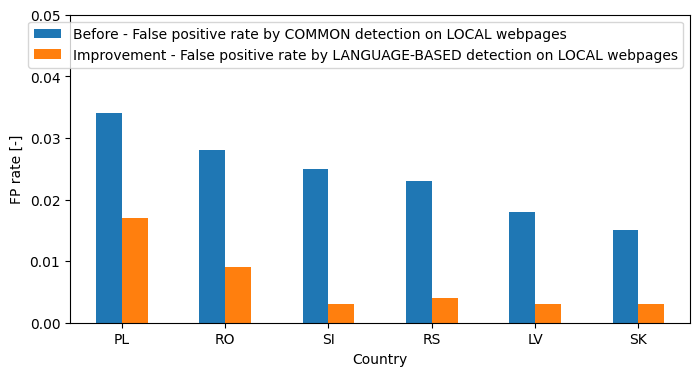

In [26]:
results_setA[['country','fp_common','fp_language']].plot.bar(
    x='country',xlabel='Country', ylabel='FP rate [-]',figsize=(8,4),rot=0,ylim=[0,0.05])
plt.legend(['Before - False positive rate by COMMON detection on LOCAL webpages',
            'Improvement - False positive rate by LANGUAGE-BASED detection on LOCAL webpages'])
plt.savefig(f'result-figures/fig-fp-country-minor-setA.pdf', bbox_inches='tight',pad_inches=0)

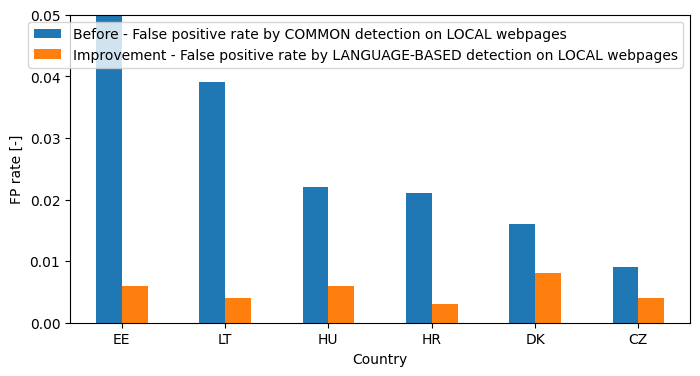

In [27]:
results_setB[['country','fp_common','fp_language']].plot.bar(
    x='country',xlabel='Country', ylabel='FP rate [-]',figsize=(8,4),rot=0,ylim=[0,0.05])
plt.legend(['Before - False positive rate by COMMON detection on LOCAL webpages',
            'Improvement - False positive rate by LANGUAGE-BASED detection on LOCAL webpages'])
plt.savefig(f'result-figures/fig-fp-country-minor-setB.pdf', bbox_inches='tight',pad_inches=0)

# Support data

In [28]:
# share of local webpages in countries on the web
sum_countries = 0
print(f'Webpages {len(generic_data)}')
counts = generic_data.tld.value_counts(normalize=True)
for item in COUNTRY_MI:
    country = counts[item.lower()]
    print(f'{item} {country.round(4)}')

Webpages 1000000
CZ 0.0114
DK 0.0058
EE 0.0016
HR 0.0021
HU 0.0067
LT 0.0017
LV 0.0011
PL 0.0139
RO 0.0045
RS 0.001
SI 0.0013
SK 0.003


CZ


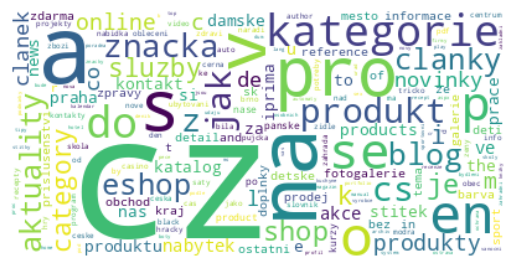

DK


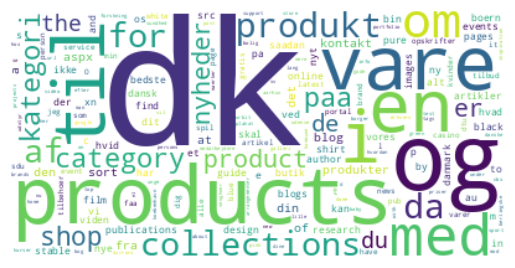

EE


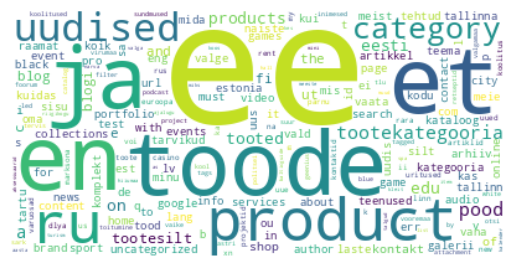

HR


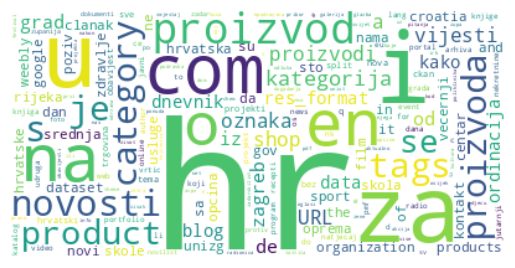

HU


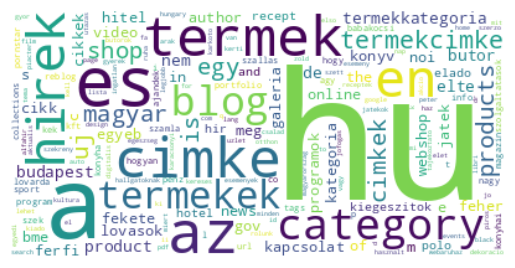

LT


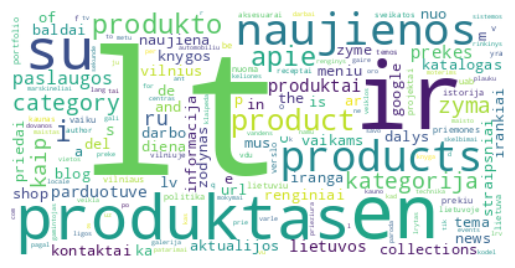

LV


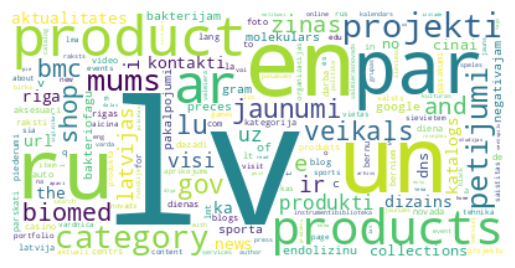

PL


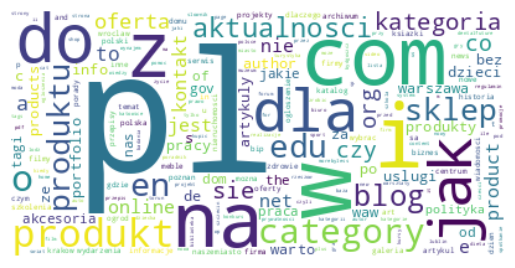

RO


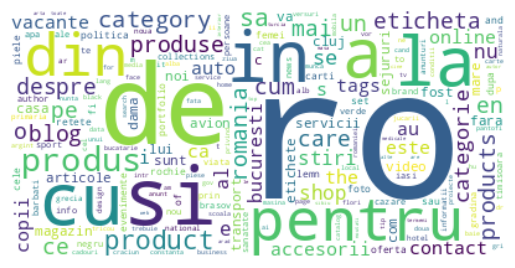

RS


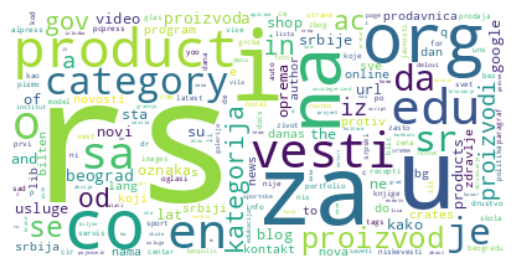

SI


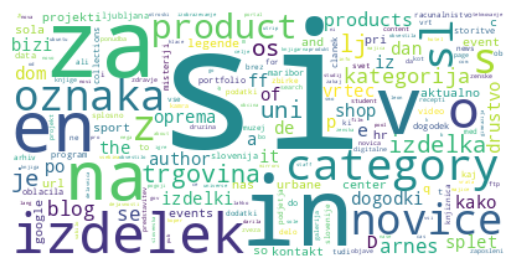

SK


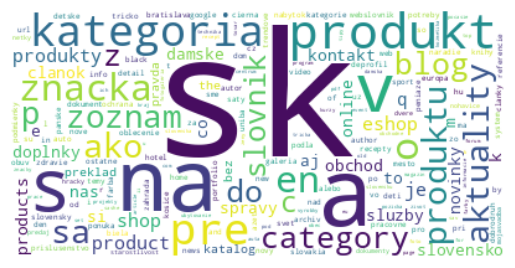

UK


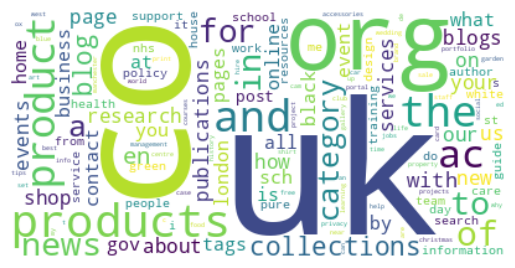

DE


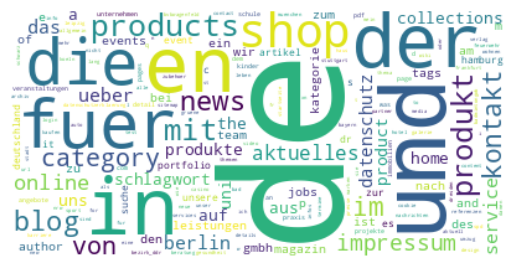

FR


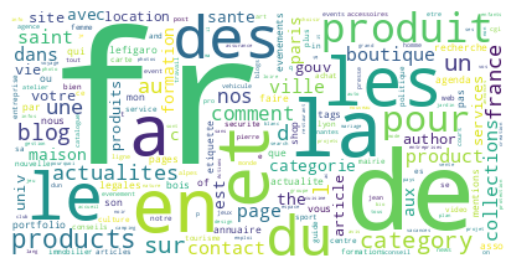

ES


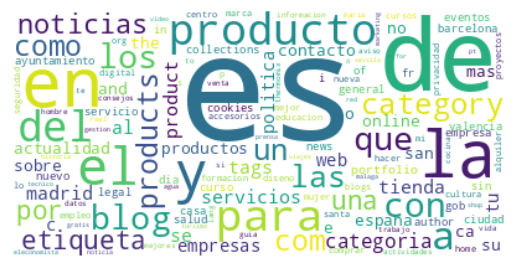

In [29]:
# word clouds for all countries
for item in COUNTRY_MI+COUNTRY_MJ:
    print(item)
    data = country_test.loc[country_test.country == item]
    plt = word_cloud(url=data.url)
    plt.savefig(f'result-figures/fig-word-cloud-{item}.pdf', bbox_inches='tight',pad_inches=0)
    plt.show()